# Tracking with SIFT features
The idea of this tracking method is to perform a matching in the n-th frame with the previous one using SIFT fetures.

First frame is going to determine the region of interest and the background. Usign SIFT features, we will extract features for both the region of interest and the background, consequently having two models.

When analyzing the folloring frames, we will apply firstly feature detection, and for each one we will find the closest match in the background model and the object model, which will determine if he point belongs to our region of interest or not. Since the region of interest window will have been displaced, we will recalculate the bounding box of this region.

Once a frame has been analyzed and the region of interest recalculated, we will update both our models, and repeat this same process for the rest of the frames.




In [1]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import sys

This function reads all the bbox of the images of file *filepath* to check if our tracker is correct

@params: 
- **file_path*** -> file path to the file taht contains the bounding boxes.

In [2]:
def getBoundingBoxes(file_path = "./MotorcycleChase/groundtruth_rect.txt"):
    boundingBoxes = {}
    with open(file_path,'r') as file:
        for line in file:
            l = line.split(',')
            id,x1,y1,width,height,visible = list(map(int,l))
            #bbox = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='red', facecolor='none')
            boundingBoxes[id] = (x1,y1,width,height)
    return boundingBoxes

Function to draw an img and also his boundÇing box

@params:

- ***img*** -> img to show.
- ***bboxPred*** -> Predicted bounding box.
- ***bboxReal*** -> Real bounging box.

In [3]:
def drawBox(img,bboxPred, bboxReal):
    x1,y1,width,height = bboxPred
    predRect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='red', facecolor='none')
    
    x2,y2,widt2,heigh2 = bboxReal
    realRect = patches.Rectangle((x2, y2), widt2, heigh2, linewidth=1, edgecolor='green', facecolor='none')
    
    fig,ax = plt.subplots()
    ax.imshow(img)
    ax.add_patch(predRect)
    ax.add_patch(realRect)
    plt.show()

Function to check if the prediction is correct, following the metric ***a***.  (A ∩ B)/(A U B) 

@params:

- ***bboxPred*** -> Predicted bounding box.
- ***bboxReal*** -> Real bounging box.

In [4]:
def getCorrectnes(bboxPred, bboxReal):
    xp, yp, wp, hp = bboxPred
    xr,yr, wr,hr = bboxReal
    
    
    x_left = max(xp, xr)
    y_top = max(yp, yr)
    x_right = min(xp + wp, xr + wr)
    y_bottom = min(yp + hp, yr + hr)
    
    if x_right < x_left or y_bottom < y_top:
      return 0
    
    intersection = (x_right - x_left) * (y_bottom - y_top)
    
    areaP = wp*hp
    areaR = wr*hr
    union = areaP + areaR - intersection
    
    return intersection / union

Method to construct a mask of 0's of the size of the iamge, with the bounding box region with 1's, in order to provide a mask for the object.

@params:

- ***img*** -> Image where bounding box should be placed.
- ***bb*** -> Bounding box to build the mask.

In [5]:
def getObjectMask(img, bb):
    mask=np.empty(img.shape, dtype=np.uint8)
    mask.fill((255))
    mask = np.zeros(img.shape, dtype=np.uint8)
    # bounding box region is white
    mask = cv2.rectangle(mask, (bb[0],bb[1]), (bb[0]+bb[2],bb[1]+bb[3]), (255,255,255), thickness = -1)
    # convert to grayscale to have only one channel
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    return mask

Method to construct a mask of 1's of the size of the image, with the bounding box region with 0's, in order to provide a mask for the background

@params:

- ***img*** -> Image where bounding box should be placed.
- ***bb*** -> Bounding box to build the mask.

In [6]:
def getBackgroundMask(img, bb):
    mask=np.empty(img.shape, dtype=np.uint8)
    # background is white
    mask.fill((255))
    # bounding box region is black
    mask = cv2.rectangle(mask, (bb[0],bb[1]), (bb[0]+bb[2],bb[1]+bb[3]), (0), thickness = -1)
    # convert to grayscale to have only one channel
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    return mask

---

Testing of extracting SIFT features of a single image.

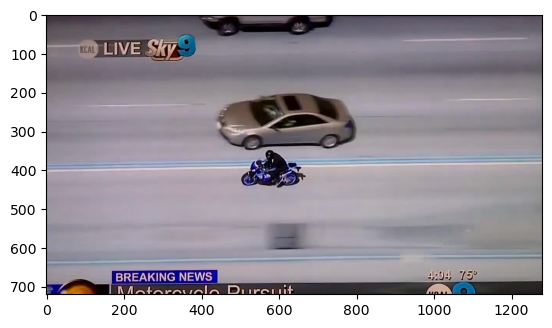

In [7]:
imgPath = "./MotorcycleChase/img/"
file = os.path.join(imgPath, "00001.jpg")
img = cv2.imread(file)
plt.imshow(img)

The idea is now to create two classes of feature points, one for the object (which will be inside the bounding box), and another for the background, that will remain outside that same box.

To do so, we will use a masked detect function, and the mask will be determined by the bounding box of the object of interest.

**void FeatureDetector::detect(const vector<Mat>& images, vector<vector<KeyPoint>>& keypoints, const vector<Mat>& masks=vector<Mat>())** const
Parameters:	
- image – Image.
- images – Image set.
- keypoints – The detected keypoints. In the second variant of the method keypoints[i] is a set of keypoints detected in images[i] .
- mask – Mask specifying where to look for keypoints (optional). It must be a 8-bit integer matrix with non-zero values in the region of interest.
- masks – Masks for each input image specifying where to look for keypoints (optional). masks[i] is a mask for images[i].

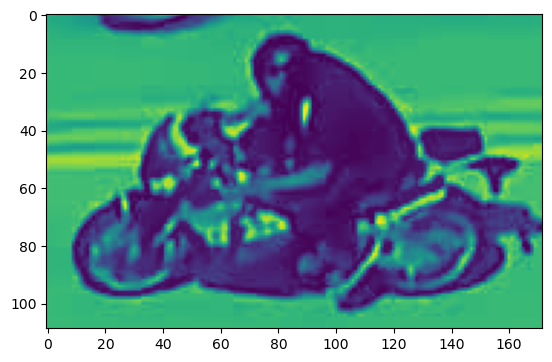

In [8]:
# calculate all bounding boxes
bbs = getBoundingBoxes()
# bounding box of the first frame
bb = bbs[1]
img = img[bb[1]:bb[1]+bb[3],bb[0]:bb[0]+bb[2]]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

Now we proceed to extract SIFT features of the biker.

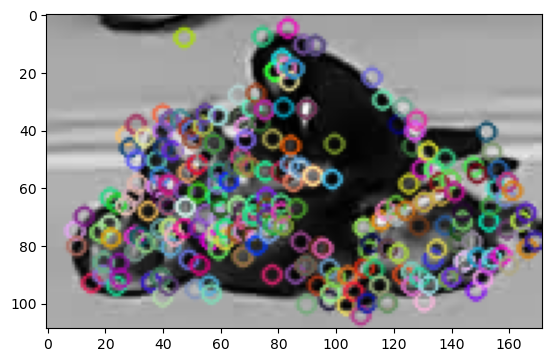

In [9]:
# create SIFT feature extractor
sift = cv2.xfeatures2d.SIFT_create() 

# detect features from the object only
objectKp, objectDescriptors = sift.detectAndCompute(img, None)
# draw the detected key points
objectFeatures = cv2.drawKeypoints(gray, objectKp, img)
# show the image
plt.imshow(objectFeatures)

---

Now that we have processed the first frame, the idea is to extract SIFT features of the following images (as a whole, withoud any masks), and extract only the keypoints that actually belong to the region of interest.

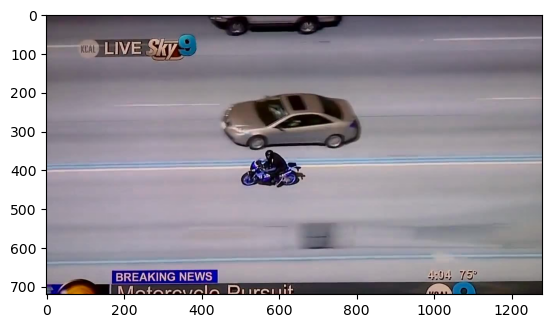

In [37]:
imgPath = "./MotorcycleChase/img/"
file = os.path.join(imgPath, "00002.jpg")
frame = cv2.imread(file)
plt.imshow(frame)

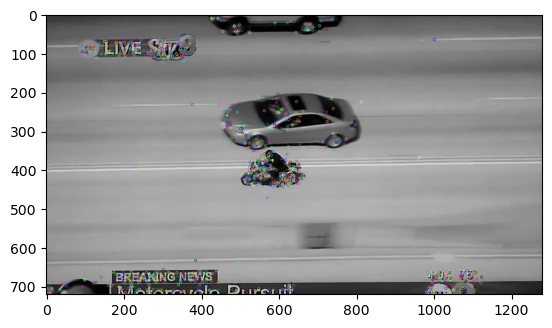

In [38]:
# detect features from the image
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frameKp, frameDescriptors = sift.detectAndCompute(frame, None)
# draw the detected key points
frameFeatures = cv2.drawKeypoints(gray, frameKp, frame)
# show the image
plt.imshow(frameFeatures)
cv2.destroyAllWindows()

Matching algorithm using Lowe distance.

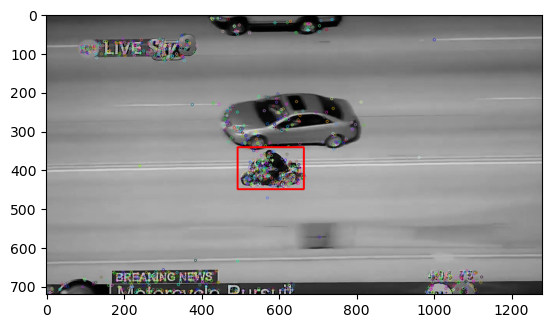

In [39]:
# create BFMatcher object for both object and background
FLANN_INDEX_KDTREE = 1
MINIMUM_MATCHES_COUNT = 5

index_params = dict(algorithm = FLANN_INDEX_KDTREE,trees  =5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(objectDescriptors, frameDescriptors, k=2)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#store only the best matches filtering with Lowe's test
bestMatches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        bestMatches.append(m)

if len(bestMatches) > MINIMUM_MATCHES_COUNT :
    src_pts = np.float32([ objectKp[m.queryIdx].pt for m in bestMatches ]).reshape(-1,1,2)
    dst_pts = np.float32([ frameKp[m.trainIdx].pt for m in bestMatches ]).reshape(-1,1,2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

    dst = cv2.perspectiveTransform(pts,M)

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

    img3 = cv2.rectangle(frame, np.int32(dst)[0][0], np.int32(dst)[2][0], (255,0,0), thickness=3)

    plt.imshow(img3)
    cv2.waitKey()

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )

Once we've checked that the model works pretty well, we proceed to build the tracker for the rest of the video, not just one frame.